The goal of this notebook is to prepare a set of images of arrows for which we will apply some group transformations, more precisely, rotation, translation about the x-axis and translation about the y-axis. Then we will save the transformed arrow images as vector embedded dataset (simple embedding, only reshaping the gray scale matrix) and try to visually identify these symmetries, both through dimensionality reduction techniques and TDA. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import gudhi
from sklearn.decomposition import PCA

In [2]:
import os
if os.path.isdir('tempDir') == False:
    os.mkdir('tempDir') 

# Rotation of the arrow about its center

Let us create the dataset of 200 arrows which are rotational symmetric about a fixed center

In [3]:
for value in range(0,200):
    fig, ax = plt.subplots()

    ax.arrow(0.5,0.5,0.3*np.cos(np.pi*value/100),0.3*np.sin(np.pi*value/100), width = 0.1, length_includes_head = True, 
             head_width = 0.3, color = 'black') #make the arrows centered at 0.5x0.5 and rotate them in a full turn in intervals
                                                # of 360/20 degrees
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.gca().set_aspect('equal', adjustable='box') #make scale of axes as similar as possible
    plt.axis('off')  
    plt.savefig('tempDir/'+'rot'+str(value)+'.png', dpi=50) #dpi controls the number of pixels used
    plt.close() 

I performed a brute force transformation to grayscale (no need to worry about 3 channels and more complex image embedding for now, which really makes life easier). Idea on how to perform it from https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python

In [4]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

from matplotlib.image import imread

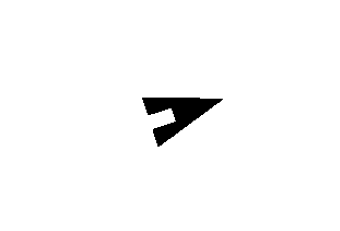

(200, 300)

In [5]:
image = imread('tempDir/'+'rot10.png')
gray = rgb2gray(image)    
plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.axis('off')
plt.show()
np.shape(gray)

Let us check whether we can see an SO_2 kind structure when we look only at the rotations.

In [6]:
rot_dataset = []
for value in range(0,200):
    image = imread('tempDir/'+'rot'+str(value)+'.png')
    gray = rgb2gray(image)    
    plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    plt.axis('off')
    np.shape(gray)
    rot_dataset.append(gray.reshape(-1))
    plt.close() 

In two dimensions

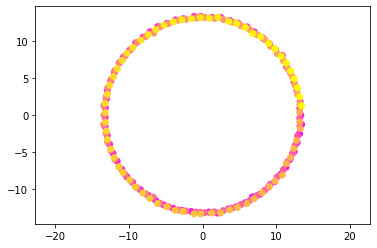

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
data = pca.fit_transform(rot_dataset)
scatter = plt.scatter(data[:,0],data[:,1], cmap = 'spring', c = range(len(data)))
plt.axis("equal")
plt.show()

So, it does look like a circle in 2 dimensions, but there is some wiggle around it. This seems to suggest that, in some higher dimensions, the object is not exactly a circle. Let us probe that

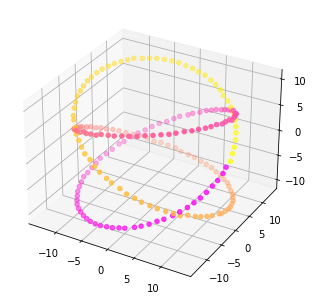

In [8]:
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
data = pca.fit_transform(rot_dataset)

fig = plt.figure()
ax = Axes3D(fig)

scatter = ax.scatter(data[:,0], data[:,1], data[:,2],cmap = 'spring', c = range(len(data)))
plt.show()

Seems like a multiple a multiple wingled circle, so it does have an SO_2 action, being however much more complicated than a simple circle though. We can try to "see" if this SO_2 action is also visible in the original very high dimensional space. Let us use some Rips filtration analysis for that end then

usetex mode requires TeX.


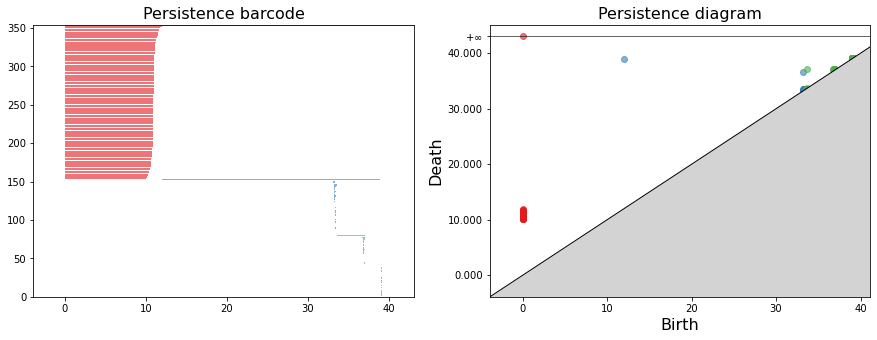

In [9]:
rips = gudhi.RipsComplex(points = rot_dataset, max_edge_length = 50)
st = rips.create_simplex_tree(max_dimension = 3)


barcodes = st.persistence(homology_coeff_field = 2)
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1); ax2 = fig.add_subplot(1,2,2)
gudhi.plot_persistence_barcode(barcodes, axes = ax1)
gudhi.plot_persistence_diagram(barcodes, axes = ax2)
plt.show()

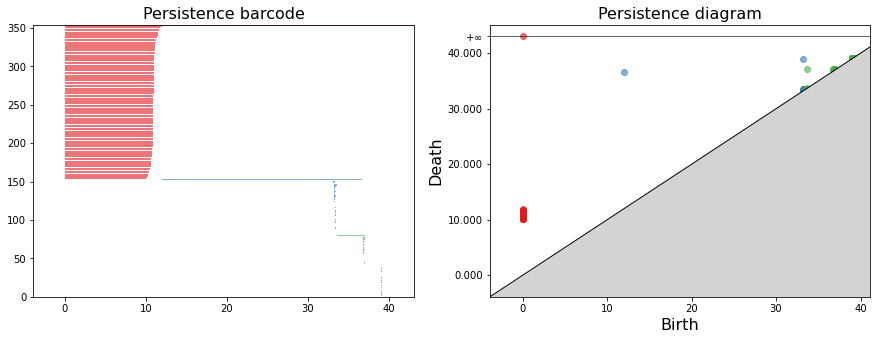

In [10]:
rips = gudhi.RipsComplex(points = rot_dataset, max_edge_length = 50)
st = rips.create_simplex_tree(max_dimension = 3)


barcodes = st.persistence(homology_coeff_field = 3)
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1); ax2 = fig.add_subplot(1,2,2)
gudhi.plot_persistence_barcode(barcodes, axes = ax1)
gudhi.plot_persistence_diagram(barcodes, axes = ax2)
plt.show()

So there is a very distinct 1-cycle, which indicates that, in fact, we can really see that the datast resembles a circle in higher dimension. This is great news as it indicates that the higher dimensional dataset still holds the SO_2 information. Let us see if we can identify which dimension that circle is embedded

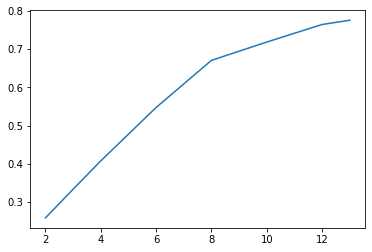

In [11]:
v = []
for i in range(13,1,-1):
    pca = PCA(n_components= i)
    pca.fit(rot_dataset)
    v.append(np.sum(pca.explained_variance_ratio_))
    
plt.plot(range(len(v))[::-1]+2*np.ones(len(v)),v)
plt.show()

It seems something like dimension 8 is an upper bound for the embedding dimension. Indeed, as the number of pixels, as well as their total intensity remains constant through the rotations, it makes sense to expect that the points lie within a circle in the embedding space, since 1. the transfomation is continuous and closed in the pixel space; 2. the norm is constant. We can check whether or not something is a circle by simply calculating the mean of the points (i.e. the center of the circle) and the avarage distance between the center and all points

In [12]:
norms = [np.linalg.norm(point)for point in rot_dataset]
np.mean(norms), np.std(norms)

(241.9912725279342, 0.017550670400855527)

It might be a good idea to see at what point of the PCA the circle stops being a cicle, which might give us a nice estimation of its embedding dimension

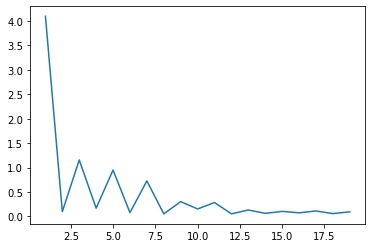

In [13]:
standard_deviations = []
for i in range(1,20):
    pca = PCA(n_components= i)
    data = pca.fit_transform(rot_dataset)
    norms = [np.linalg.norm(point)for point in data]
    standard_deviations.append(np.std(norms))
plt.plot(np.array(range(len(standard_deviations)))+np.ones(len(standard_deviations)),standard_deviations)
plt.show()

# Two rotations

Now we will look at the SO_2 symmetry applied to arrows with distinct rotation centers. This should give as orbit two disjoint circle-like structures like the one seen in the single rotation case, which may or may not enclose each other.

In [14]:
for value in range(0,200):
    fig, ax = plt.subplots()

    ax.arrow(1 , 1,0.3*np.cos(np.pi*value/100),0.3*np.sin(np.pi*value/100), width = 0.1, length_includes_head = True, 
             head_width = 0.3, color = 'black')
    ax.set_xlim([0, 3])
    ax.set_ylim([0, 3])
    plt.gca().set_aspect('equal', adjustable='box') #make scale of axes as similar as possible
    plt.axis('off')  
    plt.savefig('tempDir/'+'two_rot_1'+str(value)+'.png', dpi=50) #dpi controls the number of pixels used
    plt.close() 
    
for value in range(0,200):
    fig, ax = plt.subplots()

    ax.arrow(2, 2,0.3*np.cos(np.pi*value/100),0.3*np.sin(np.pi*value/100), width = 0.1, length_includes_head = True, 
             head_width = 0.3, color = 'black')
    ax.set_xlim([0, 3])
    ax.set_ylim([0, 3])
    plt.gca().set_aspect('equal', adjustable='box') #make scale of axes as similar as possible
    plt.axis('off')  
    plt.savefig('tempDir/'+'two_rot_2'+str(value)+'.png', dpi=50) #dpi controls the number of pixels used
    plt.close() 

In [15]:
rot_dataset_1 = []
for value in range(0,200):
    image = imread('tempDir/'+'two_rot_1'+str(value)+'.png')
    gray = rgb2gray(image)    
    plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    plt.axis('off')
    np.shape(gray)
    rot_dataset_1.append(gray.reshape(-1))
    plt.close() 

label_rot_1 = []
for i in range(len(rot_dataset_1)):
    label_rot_1.append(0)
    
rot_dataset_2 = []
for value in range(0,200):
    image = imread('tempDir/'+'two_rot_2'+str(value)+'.png')
    gray = rgb2gray(image)    
    plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    plt.axis('off')
    np.shape(gray)
    rot_dataset_2.append(gray.reshape(-1))
    plt.close() 

label_rot_2 = []
for i in range(len(rot_dataset_2)):
    label_rot_2.append(1)

In [16]:
full_dataset = rot_dataset_1 + rot_dataset_2 
full_label =  label_rot_1 + label_rot_2

As we are looking for two distinct circles, the spanned space should be embedded, at least, in dimension 3. So PCAing to that dimension

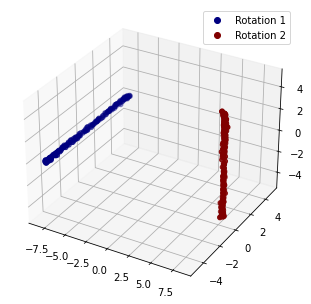

In [17]:
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
data = pca.fit_transform(full_dataset)

fig = plt.figure()
ax = Axes3D(fig)

classes = ['Rotation 1', 'Rotation 2']
scatter = ax.scatter(data[:,0], data[:,1], data[:,2], c = full_label, cmap = "jet")
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.show()

Not so good, PCA is straightening the circles. Let us see how ISOMAP does it

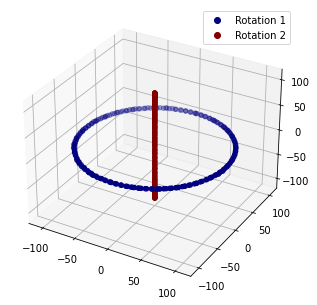

In [18]:
from sklearn.manifold import Isomap
embedding = Isomap(n_components=3)
data = embedding.fit_transform(full_dataset)

fig = plt.figure()
ax = Axes3D(fig)

classes = ['Rotation 1', 'Rotation 2']
scatter = ax.scatter(data[:,0], data[:,1], data[:,2], c = full_label, cmap = "jet")
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.show()

Better! Even though one of the circles was straighted, the other is prettu much preserved. This indicates us three things: 1. dimension where the spanned space might be distinquisheable is at least 4; 2. there indeed seems to be two circles (ISOMAP "chooses" one to straight out, but by symmetry, the straighted one should also have been a circle at some dimension bigger than 4);3. the blue circle seems to have the same kind of "shaky" structure which the rotations in the last problem show, so we might as well assume that the circle is, indeed, not a perfect circle, but something that looks like what was seen in the previous example. To actually probe if that is the case, we can look at the Rips complex for 2 1-cycles.

<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

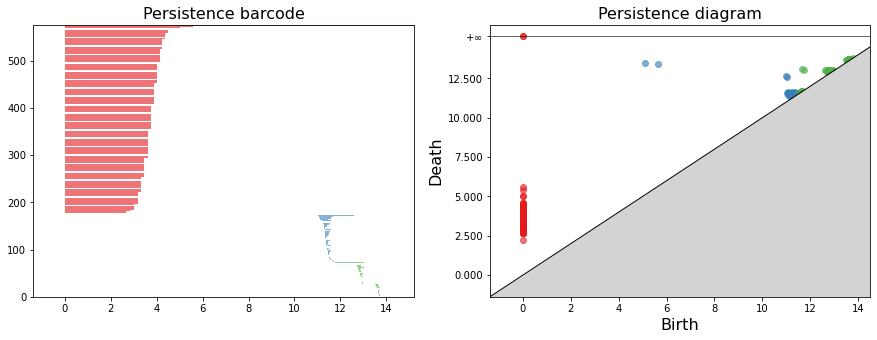

In [19]:
rips = gudhi.RipsComplex(points = full_dataset, max_edge_length = 14)
st = rips.create_simplex_tree(max_dimension = 3)


barcodes = st.persistence(homology_coeff_field = 2)
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1); ax2 = fig.add_subplot(1,2,2)
gudhi.plot_persistence_barcode(barcodes, axes = ax1)
gudhi.plot_persistence_diagram(barcodes, axes = ax2)

Perfect! Two 1-cycles detected! Let us get some extimations of the embedding dimensions

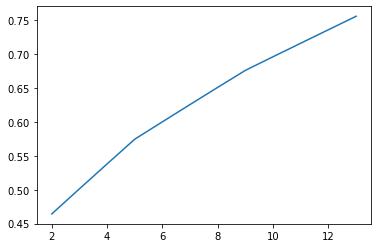

In [20]:
v = []
for i in range(13,1,-1):
    pca = PCA(n_components= i)
    pca.fit(full_dataset)
    v.append(np.sum(pca.explained_variance_ratio_))
    
plt.plot(range(len(v))[::-1]+2*np.ones(len(v)),v)
plt.show()

This time, dimension 5 seems like an upper bound

# Adding truncated translations

The big problem with studying translational symmetries for images is that, for a perfect approach, it requires an infinite plane of pixels. That is clear impossible, so we have basically 3 options:
1. Truncated translation: truncate the translations so that we do not consider points where the arrows would be cropped by the edge of the pixel matrix
2. Non-periodic translation: simply let the arrows be cropped when leaving the pixel matrix area
3. Periodic translation: when the arrow leaves the pixel area, another identical arrow enters through the opposite side

Of these, only 1 and 3 approximate well what translation symmetry is supposed to look like, being the elements of 1 a simpler-to-implement subset of 3. Notice, however, that as 3 represents a circular symmetry, we expect 1 to be something like an "arc" symmetry.

In [21]:
for value in range(0,100): 
    fig, ax = plt.subplots()

    ax.arrow(0.3+value*0.005,0.5,0,0.3, width = 0.1, length_includes_head = True, 
             head_width = 0.3, color = 'black')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis('off')  
    plt.savefig('tempDir/'+'x_trans'+str(value)+'.png', dpi=50)
    plt.close() 

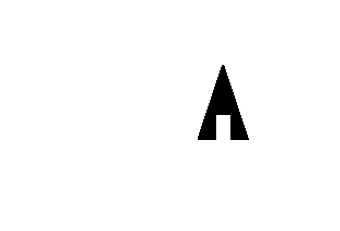

(200, 300)

In [22]:
image = imread('tempDir/'+'x_trans99.png')
gray = rgb2gray(image)    
plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.axis('off')
plt.show()
np.shape(gray)

In [23]:
x_trans_dataset = []
for value in range(0,100):
    image = imread('tempDir/'+'x_trans'+str(value)+'.png')
    gray = rgb2gray(image)    
    plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    plt.axis('off')
    np.shape(gray)
    x_trans_dataset.append(gray.reshape(-1))
    plt.close() 

Let us look at the embeddings

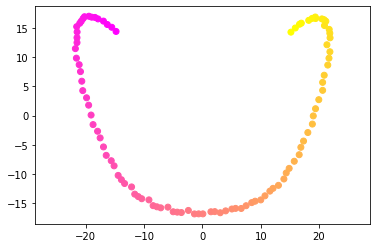

In [24]:
pca = PCA(n_components=2)
data = pca.fit_transform(x_trans_dataset)
scatter = plt.scatter(data[:,0],data[:,1], cmap = 'spring', c = range(len(data)))
plt.axis("equal")
plt.show()

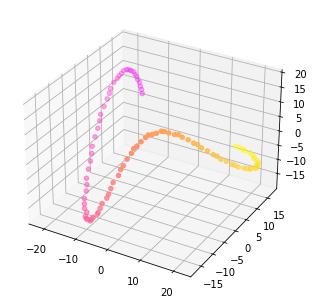

In [25]:
pca = PCA(n_components=3)
data = pca.fit_transform(x_trans_dataset)
fig = plt.figure()
ax = Axes3D(fig)

classes = ['Rotation 1', 'Rotation 2']
scatter = ax.scatter(data[:,0], data[:,1], data[:,2],cmap = 'spring', c = range(len(data)))
plt.show()

So, we do get again something like a multiple winged circle (or rather arc now), just as we saw for the roations around a fixed point.

# Mix of 2 translations

Let us now see how the dataset behaves when we have two translations as degrees of freemdom. Now, the dataset should be lie within a 2D manifold, so let us check how the dataset behaves for this 2D orbit space.

In [26]:
for x in range(0,10):
    for y in range(0,9):
        fig, ax = plt.subplots()

        ax.arrow(0.3+x*0.05,0.3+y*0.05,0,0.3, width = 0.1, length_includes_head = True, 
                 head_width = 0.3, color = 'black')
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        plt.gca().set_aspect('equal', adjustable='box')
        plt.axis('off')  
        plt.savefig('tempDir/'+'two_trans'+str(x)+'-'+str(y)+'.png', dpi=50)
        plt.close() 

In [27]:
two_translation = []
for x in range(0,10):
    for y in range(0,9):
        image = imread('tempDir/'+'two_trans'+str(x)+'-'+str(y)+'.png')
        gray = rgb2gray(image)    
        plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
        plt.axis('off')
        np.shape(gray)
        two_translation.append(gray.reshape(-1))
        plt.close() 

We expect the result to be a the product of the two winged circle (arc) structures, which should be a 2D object that looks something like a subset of a winged torus.

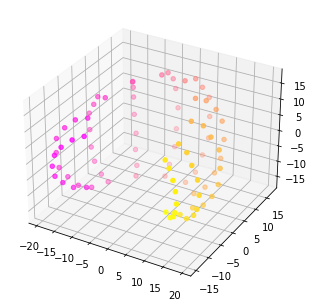

In [28]:
pca = PCA(n_components=3)
data = pca.fit_transform(two_translation)

fig = plt.figure()
ax = Axes3D(fig)

scatter = ax.scatter(data[:,0], data[:,1], data[:,2], cmap = 'spring', c = range(len(data)))
plt.show()

Which does look like a torus! Let us again check for embedding dimension

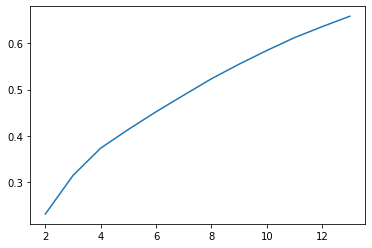

In [29]:
v = []
for i in range(13,1,-1):
    pca = PCA(n_components= i)
    pca.fit(two_translation)
    v.append(np.sum(pca.explained_variance_ratio_))
    
plt.plot(range(len(v))[::-1]+2*np.ones(len(v)),v)
plt.show()

Now dimension 3 seems good enough. This means that what we are seeing in the image is, in fact, something very similar to a torus

# Periodic translations

Finally, let us look at the space spanned by periodic translations. As they are periodic, we expect orbits to be closed versions of the arc structure seem for the truncated translations

In [30]:
for value in np.linspace(0, 1, num=200):    
    fig, ax = plt.subplots()
    if value<0.1:
        ax.arrow(1+value,0.5,0,0.2, width = 0.1, length_includes_head = True, head_width = 0.2, color = 'black')
        ax.arrow(value,0.5,0,0.2, width = 0.1, length_includes_head = True, 
                 head_width = 0.2, color = 'black')
    elif value>0.9:
        ax.arrow(0-(1-value),0.5,0,0.2, width = 0.1, length_includes_head = True, head_width = 0.2, color = 'black')
        ax.arrow(value,0.5,0,0.2, width = 0.1, length_includes_head = True, 
                 head_width = 0.2, color = 'black')
    else:
        ax.arrow(value,0.5,0,0.2, width = 0.1, length_includes_head = True, 
                 head_width = 0.2, color = 'black')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.gca().set_aspect('equal', adjustable='box') 
    plt.axis('off')  
    plt.savefig('tempDir/'+'periodic'+str(value)+'.png', dpi=50) #dpi controls the number of pixels used
    plt.close() 
    

In [31]:
periodic_dataset = []
for value in np.linspace(0, 1, num=200):
    image = imread('tempDir/'+'periodic'+str(value)+'.png')
    gray = rgb2gray(image)    
    plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    plt.axis('off')
    np.shape(gray)
    periodic_dataset.append(gray.reshape(-1))
    plt.close() 

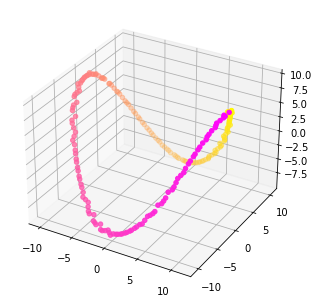

In [32]:
pca = PCA(n_components=3)
data = pca.fit_transform(periodic_dataset)

fig = plt.figure()
ax = Axes3D(fig)

scatter = ax.scatter(data[:,0], data[:,1], data[:,2], cmap = 'spring', c = range(len(data)))
plt.show()

Exactly as expected from the 2 rotations example, that is, something topologically equivalent to a cicle.

<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

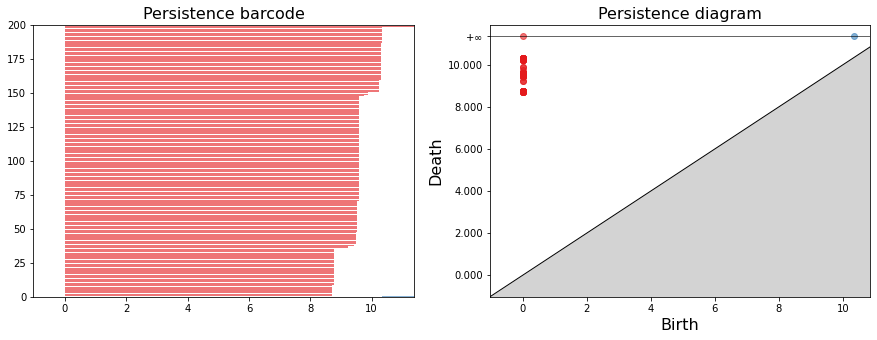

In [33]:
rips = gudhi.RipsComplex(points = periodic_dataset, max_edge_length = 20)
st = rips.create_simplex_tree(max_dimension = 3)


barcodes = st.persistence(homology_coeff_field = 2)
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1); ax2 = fig.add_subplot(1,2,2)
gudhi.plot_persistence_barcode(barcodes, axes = ax1)
gudhi.plot_persistence_diagram(barcodes, axes = ax2)

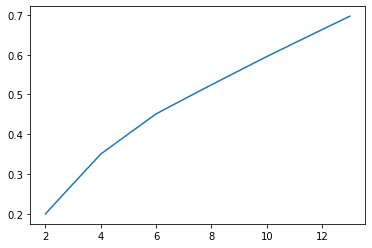

In [34]:
v = []
for i in range(13,1,-1):
    pca = PCA(n_components= i)
    pca.fit(periodic_dataset)
    v.append(np.sum(pca.explained_variance_ratio_))
    
plt.plot(range(len(v))[::-1]+2*np.ones(len(v)),v)
plt.show()

Now dimesnion 4 semms like a good embedding dimension

In [35]:
import shutil

shutil.rmtree('tempDir')